<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-configurations-for-importing-data" data-toc-modified-id="Prepare-configurations-for-importing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare configurations for importing data</a></span></li><li><span><a href="#Import-studies-and-limit-to-drugs-/-2018" data-toc-modified-id="Import-studies-and-limit-to-drugs-/-2018-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import studies and limit to drugs / 2018</a></span></li><li><span><a href="#Import-browse-trial---MeSH-terms" data-toc-modified-id="Import-browse-trial---MeSH-terms-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import browse trial - MeSH terms</a></span></li><li><span><a href="#Cartesian-join-trials-with-MeSH-information-for-comparisons" data-toc-modified-id="Cartesian-join-trials-with-MeSH-information-for-comparisons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cartesian join trials with MeSH information for comparisons</a></span></li><li><span><a href="#Import-MeSH-hierarchy" data-toc-modified-id="Import-MeSH-hierarchy-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Import MeSH hierarchy</a></span></li><li><span><a href="#Identify-which-conditions-and-interventions-are-not-in-the-hierarchy" data-toc-modified-id="Identify-which-conditions-and-interventions-are-not-in-the-hierarchy-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Identify which conditions and interventions are not in the hierarchy</a></span></li><li><span><a href="#Custom-Hierarchy-similarity-measure" data-toc-modified-id="Custom-Hierarchy-similarity-measure-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Custom Hierarchy similarity measure</a></span></li><li><span><a href="#Loop-over-similarities-and-fill-in-matrix" data-toc-modified-id="Loop-over-similarities-and-fill-in-matrix-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Loop over similarities and fill in matrix</a></span></li><li><span><a href="#Sanity-check-results" data-toc-modified-id="Sanity-check-results-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Sanity check results</a></span></li></ul></div>

## Prepare configurations for importing data

In [20]:
import json
import pandas as pd
import psycopg2
import numpy as np
from sklearn.preprocessing import normalize
from tqdm import tqdm_notebook
import re

from datetime import datetime
import matplotlib.pyplot as plt
from scipy import sparse

import ipywidgets as widgets

pd.options.mode.chained_assignment = None

In [2]:
with open('config.json') as f:
    conf = json.load(f)
conn_str = "host={} dbname={} port={} user={} password={}".format(conf['host'],
                                                                  conf['database'],
                                                                  conf['port'],
                                                                  conf['user'],
                                                                  conf['passw'])
conn = psycopg2.connect(conn_str)

## Import studies and limit to drugs / 2018

In [3]:
studies = pd.read_sql('select * from studies', con=conn)

In [4]:
studies_drugs = studies[studies['is_fda_regulated_drug']==True]
studies_drugs['start_year'] = pd.to_datetime(studies_drugs['start_date']).dt.year

In [5]:
# Create indices for each nct_id
def create_year_index(year):
    yearlim=studies_drugs['start_year']==year
    
    study_index = {v:k for k,v in enumerate(studies_drugs[yearlim]['nct_id'])}
    study_index_rev = {k:v for k,v in enumerate(studies_drugs[yearlim]['nct_id'])}
    
    return study_index, study_index_rev

In [6]:
study_index_2018, study_index_rev_2018 = create_year_index(2018)
study_index_2017, study_index_rev_2017 = create_year_index(2017)
study_index_2016, study_index_rev_2016 = create_year_index(2016)
study_index_2015, study_index_rev_2015 = create_year_index(2015)

## Import browse trial - MeSH terms

In [7]:
browse_conditions = pd.read_sql('select * from browse_conditions', con=conn)
browse_interventions = pd.read_sql('select * from browse_interventions', con=conn)

## Cartesian join trials with MeSH information for comparisons

In [8]:
def rootTerm(x):
    try:
        return terms[x][:3]
    except:
        return None
        

def preprocess_xjoin(df_mesh,year):
    # Limit trials to specific year
    yearlim=studies_drugs['start_year']==year
    
    # Merge MeSH numbers onto dataframe
    df_mesh_year = df_mesh.merge(studies_drugs[yearlim],on=['nct_id'])[['nct_id','downcase_mesh_term']]
    df_mesh_year['root_mesh_number']=df_mesh_year['downcase_mesh_term'].apply(lambda x: rootTerm(x))
    
    # Perform a full trial*trial cartesian join
    df_mesh_year['key']=1
    df_mesh_year_xjoin = pd.merge(df_mesh_year, df_mesh_year,on='key')


    # Keep trials that have at least one root of hierarchy in common or they are the same term
    rootdiff_lim = (df_mesh_year_xjoin['root_mesh_number_x']==df_mesh_year_xjoin['root_mesh_number_y'])&(df_mesh_year_xjoin['root_mesh_number_x']!=None)
    sameterm_lim = df_mesh_year_xjoin['downcase_mesh_term_x']==df_mesh_year_xjoin['downcase_mesh_term_y']

    
    # Remove trials that compare with themselves
    nctid_lim = df_mesh_year_xjoin['nct_id_x'] != df_mesh_year_xjoin['nct_id_y']

    df_mesh_year_xjoin=df_mesh_year_xjoin[nctid_lim & (rootdiff_lim | sameterm_lim)]
    
    return df_mesh_year, df_mesh_year_xjoin


In [9]:
browse_conditions_2018, browse_conditions_2018_xjoin = preprocess_xjoin(browse_conditions, 2018)

In [10]:
browse_conditions_2017, browse_conditions_2017_xjoin = preprocess_xjoin(browse_conditions, 2017)

In [11]:
browse_conditions_2016, browse_conditions_2016_xjoin = preprocess_xjoin(browse_conditions, 2016)

In [12]:
browse_conditions_2015, browse_conditions_2015_xjoin = preprocess_xjoin(browse_conditions, 2015)

In [13]:
browse_interventions_2018, browse_interventions_2018_xjoin = preprocess_xjoin(browse_interventions, 2018)

In [14]:
browse_interventions_2017, browse_interventions_2017_xjoin = preprocess_xjoin(browse_interventions, 2017)

In [15]:
browse_interventions_2016, browse_interventions_2016_xjoin = preprocess_xjoin(browse_interventions, 2016)

In [16]:
browse_interventions_2015, browse_interventions_2015_xjoin = preprocess_xjoin(browse_interventions, 2015)

In [17]:
print("Number of 2018 conditions: {0:,}".format(browse_conditions_2018_xjoin.shape[0]))
print("Number of 2017 conditions: {0:,}".format(browse_conditions_2017_xjoin.shape[0]))
print("Number of 2016 conditions: {0:,}".format(browse_conditions_2016_xjoin.shape[0]))
print("Number of 2015 conditions: {0:,}".format(browse_conditions_2015_xjoin.shape[0]))
print("\nNumber of 2018 interventions: {0:,}".format(browse_interventions_2018_xjoin.shape[0]))
print("Number of 2017 interventions: {0:,}".format(browse_interventions_2017_xjoin.shape[0]))
print("Number of 2016 interventions: {0:,}".format(browse_interventions_2016_xjoin.shape[0]))
print("Number of 2015 interventions: {0:,}".format(browse_interventions_2015_xjoin.shape[0]))

Number of 2018 conditions: 439,018
Number of 2017 conditions: 399,194
Number of 2016 conditions: 31,624
Number of 2015 conditions: 23,604

Number of 2018 interventions: 425,152
Number of 2017 interventions: 388,362
Number of 2016 interventions: 30,974
Number of 2015 interventions: 17,264


## Import MeSH hierarchy

In [18]:
meshFile = 'd2018.bin'
with open(meshFile, mode='rb') as file:
    mesh = file.readlines()

In [21]:
numbers=dict()
terms=dict()

for line in mesh:
    meshTerm = re.search(b'MH = (.+)$', line)
    if meshTerm:
        term = meshTerm.group(1).lower()

    meshNumber = re.search(b'MN = (.+)$', line)
    if meshNumber:
        number = meshNumber.group(1)
        
        numbers[number.decode('utf-8')] = term.decode('utf-8')
        
        # If term has more than one number, concatenate separated by space
        if term in terms:
            terms[term.decode('utf-8')] = terms[term.decode('utf-8')] + ' ' + number.decode('utf-8')
        else:
            terms[term.decode('utf-8')] = number.decode('utf-8')

In [22]:
df_terms = pd.DataFrame.from_dict(terms, orient='index').reset_index()
df_terms.columns=['term','number']

## Identify which conditions and interventions are not in the hierarchy

In [23]:
def find_missing_terms(df,year):
    yearlim=yearlim=studies_drugs['start_year']==year
    df_set = set(df.merge(studies_drugs[yearlim],on=['nct_id'])['downcase_mesh_term'])
    terms_set = set(terms.keys())
    return df_set-terms_set


print("BROWSE CONDITIONS")
for yr in range(2016,2019):
    print("{} {}".format(yr,find_missing_terms(browse_conditions,yr)))
    
# print("\nBROWSE INTERVENTIONS")
# for yr in range(2018,2019):
#     print("{} {}".format(yr,find_missing_terms(browse_interventions,yr)))

BROWSE CONDITIONS
2016 set()
2017 {'metabolic syndrome x'}
2018 {'metabolic syndrome x'}


## Custom Hierarchy similarity measure

In [59]:
def hierarchy_sim(term, compare):
    num_branches = (len(term)+1)//4
    num_compare_branches = (len(compare)+1)//4
    iterations = min(num_branches,num_compare_branches)
    
    if num_branches*num_compare_branches == 0:
        return 0
    
    if term==compare:
        return max(num_branches,num_compare_branches)

    for i in range(1,iterations+1):
        if term[:i*4-1]!=compare[:i*4-1]:
            return (i-1)
    
    return iterations

## Loop over similarities and fill in matrix

In [60]:
def loopComparison(df,study_index):
    comparison = sparse.lil_matrix((len(study_index),len(study_index)))

    for index, row in df.iterrows():
        nct_id_indx = study_index[row['nct_id_x']]
        nct_id_compare_indx = study_index[row['nct_id_y']]

        term=row['downcase_mesh_term_x']
        term_compare=row['downcase_mesh_term_y']

        if nct_id_indx != nct_id_compare_indx:
            comparison[nct_id_indx,nct_id_compare_indx] += hierarchy_sim(term, term_compare)

    # Normalize matrix row-wise
    return normalize(comparison.tocsr(), norm='max', axis=1)

In [ ]:
condition_comparison_2018=loopComparison(browse_conditions_2018_xjoin,study_index_2018)

In [ ]:
condition_comparison_2017=loopComparison(browse_conditions_2017_xjoin,study_index_2017)

In [ ]:
condition_comparison_2016=loopComparison(browse_conditions_2016_xjoin,study_index_2016)

In [ ]:
condition_comparison_2015=loopComparison(browse_conditions_2015_xjoin,study_index_2015)

In [ ]:
intervention_comparison_2018=loopComparison(browse_interventions_2018_xjoin,study_index_2018)

In [ ]:
intervention_comparison_2017=loopComparison(browse_interventions_2017_xjoin,study_index_2017)

In [ ]:
intervention_comparison_2016=loopComparison(browse_interventions_2016_xjoin,study_index_2016)

In [ ]:
intervention_comparison_2015=loopComparison(browse_interventions_2015_xjoin,study_index_2015)

## Sanity check results

In [32]:
def returnTopSim(df,study_index,study_index_rev,nct_id, n=10):
    index = study_index[nct_id]
    list = [(v, k) for k, v in enumerate(df[index].toarray().flatten())]
    list.sort(reverse=True)
    
    topn = []
     
    for i in list[:n]:
        topn.append((study_index_rev[i[1]],i[0]))
    return topn

In [35]:
returnTopSim(condition_comparison_2018,study_index_2018,study_index_rev_2018,'NCT03652077',20)

[('NCT03538028', 1.0),
 ('NCT03517488', 0.6391752577319587),
 ('NCT03319459', 0.5051546391752577),
 ('NCT03694249', 0.4845360824742268),
 ('NCT03590054', 0.4742268041237113),
 ('NCT03454451', 0.44329896907216493),
 ('NCT03236935', 0.422680412371134),
 ('NCT03633110', 0.422680412371134),
 ('NCT03602079', 0.38144329896907214),
 ('NCT03621982', 0.3711340206185567),
 ('NCT03509012', 0.36082474226804123),
 ('NCT03435640', 0.36082474226804123),
 ('NCT03552718', 0.32989690721649484),
 ('NCT03409458', 0.31958762886597936),
 ('NCT03576131', 0.30927835051546393),
 ('NCT03485209', 0.29896907216494845),
 ('NCT03474497', 0.29896907216494845),
 ('NCT03502330', 0.27835051546391754),
 ('NCT03549000', 0.25773195876288657),
 ('NCT03265080', 0.23711340206185566)]

In [36]:
def print_terms(df,nct_id1,nct_id2):
    print(f"{nct_id1}:")
    for i in df.loc[df['nct_id']==nct_id1]['downcase_mesh_term']:
        try:
            print(f"{i}: {terms[i]}")
        except:
            print(f"{i}: N/A")

    print(f"\n{nct_id2}:")
    for i in df.loc[browse_conditions_2018['nct_id']==nct_id2]['downcase_mesh_term']:
        try:
            print(f"{i}: {terms[i]}")
        except:
            print(f"{i}: N/A")

In [38]:
print_terms(browse_interventions_2018,'NCT03652077','NCT03538028')

NCT03652077:
immunoglobulins: D12.776.377.715.548

NCT03538028:
bupivacaine: D03.383.621.758.323
ropivacaine: N/A
antibodies: D12.776.377.715.548.114
immunoglobulins: D12.776.377.715.548
antibodies, monoclonal: D12.776.377.715.548.114.224
rifampin: D04.345.295.750.700
rifapentine: N/A
isoniazid: D03.383.725.394.582
rifamycins: D04.345.295.750
rifamycin sv: N/A
pharmaceutical solutions: D27.720.752
cantharidin: D03.633.100.127.125
antibodies, monoclonal: D12.776.377.715.548.114.224
antibodies: D12.776.377.715.548.114
antibodies, monoclonal: D12.776.377.715.548.114.224
daratumumab: N/A
celecoxib: D03.383.129.539.160
diclofenac: D02.241.223.601.210
indomethacin: D03.633.100.473.420
meloxicam: N/A
anti-inflammatory agents: D27.505.954.158


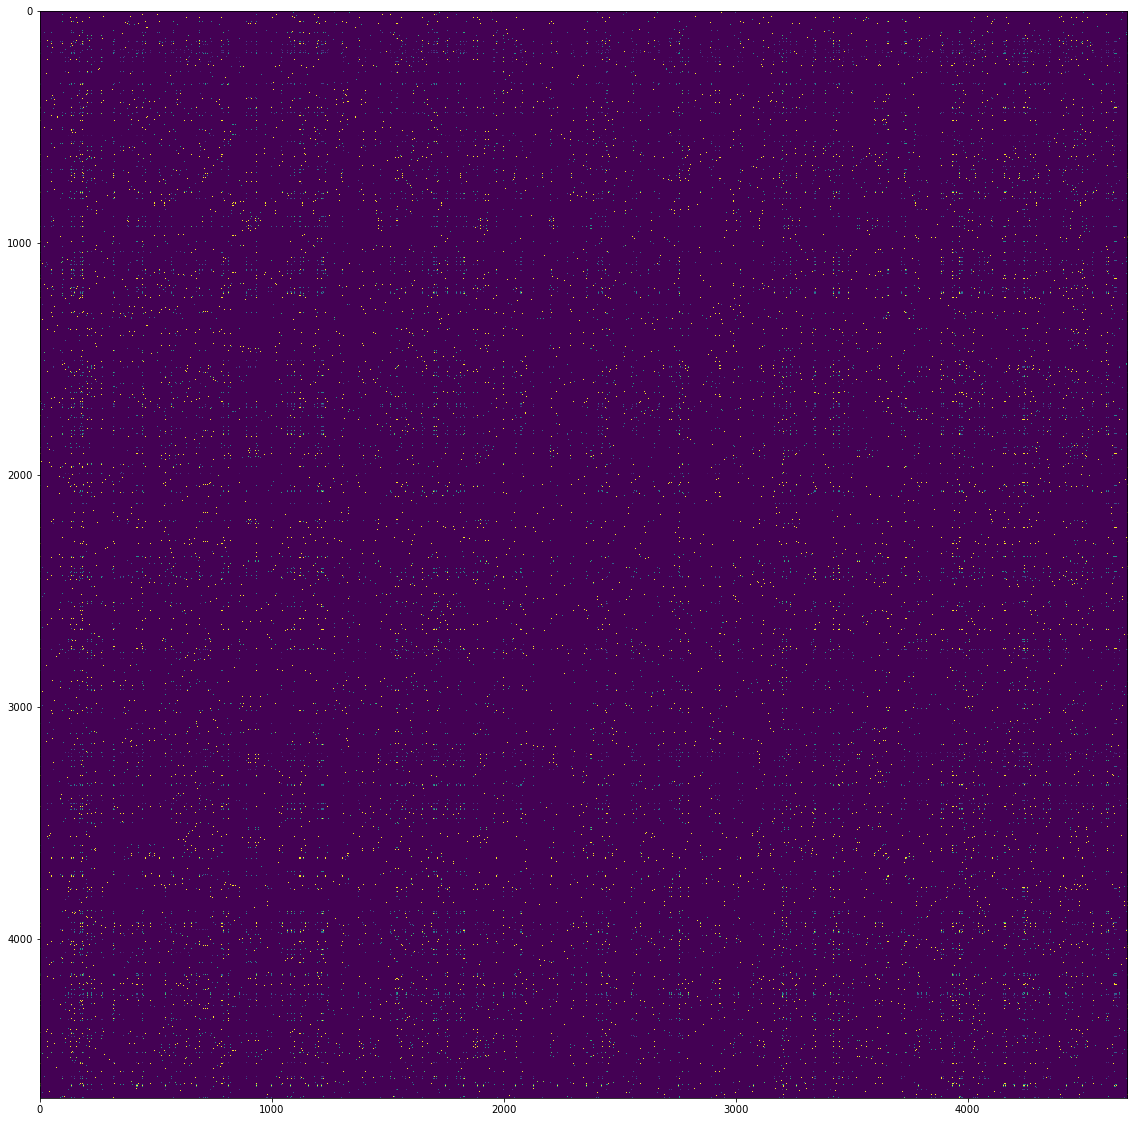

In [58]:
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(condition_comparison_2018.todense(), interpolation='none')